## Load the brain

In [1]:
import numpy as np

In [2]:
bs = np.load('./brain/000034_1_bs.npz')
print(np.all(bs))

In [3]:
for i in bs:
    print(i)

spacing
label


In [4]:
bs['spacing']

array([1.25    , 0.585938, 0.585938])

In [5]:
label = bs['label'].transpose(2,0,1)

In [6]:
label.shape

(224, 512, 512)

In [7]:
ct = np.load('./brain/000034_1_ctscan.npz')
for i in ct:
    print(i)

img
spacing


In [8]:
ctimg = ct['img'].transpose(2,0,1)

In [9]:
ctimg.shape

(224, 512, 512)

In [10]:
ct['spacing']

array([1.25    , 0.585938, 0.585938])

## Plot brain CT and Tumor label

In [11]:
import matplotlib.pyplot as plt

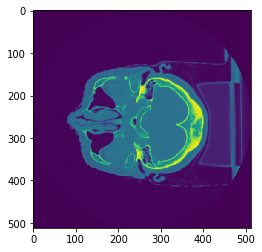

In [12]:
plt.imshow(ct['img'][:,:,100])

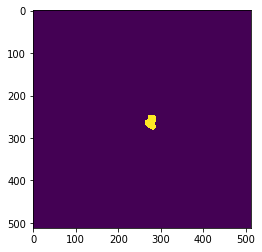

In [13]:
plt.imshow(bs['label'][:,:,100])

## Cut dataset

In [14]:
import random

In [15]:
# Parameters settings
seed = 1734
split_rate = 0.75

In [16]:
rdn = np.arange(5)
rdn=np.random.permutation(rdn)

In [17]:
rdn

array([4, 0, 2, 3, 1])

In [18]:
num = np.arange(25).reshape((5,5))
num

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [19]:
num[rdn,...]

array([[20, 21, 22, 23, 24],
       [ 0,  1,  2,  3,  4],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [ 5,  6,  7,  8,  9]])

In [20]:
random.seed(seed)
random_number = np.arange(ctimg.shape[0])
random_number = np.random.permutation(random_number)

In [21]:
trainX = ctimg[random_number[:int(ctimg.shape[0]*split_rate)] ,...]
trainY = label[random_number[:int(ctimg.shape[0]*split_rate)] ,...]
testX = ctimg[random_number[int(ctimg.shape[0]*split_rate):] ,...]
testY = label[random_number[int(ctimg.shape[0]*split_rate):] ,...]

In [22]:
print("Training data  shape: {}".format(trainX.shape))
print("Training label shape: {}".format(trainY.shape))
print("Testing  data  shape: {}".format(testX.shape))
print("Testing  label shape: {}".format(testY.shape))

Training data  shape: (168, 512, 512)
Training label shape: (168, 512, 512)
Testing  data  shape: (56, 512, 512)
Testing  label shape: (56, 512, 512)


## YOLO

### preprocessing

In [23]:
from skimage import data,color,morphology,feature, measure

In [24]:
label.shape

(224, 512, 512)

In [25]:
def get_value_in_bdbox( label_image):
    
    initial = True
    exist_value = False
    for num_slice in np.arange(label_image.shape[0]):
        for region in measure.regionprops(label_image[int(num_slice),...]):
            if np.max(label_image[int(num_slice),...]) == 1:
                minr, minc, maxr, maxc = region.bbox
                exist_value = True
                
        if  exist_value:  
            box_infor = np.array([ int(num_slice), None, None, int(maxr-minr), int(maxc-minc)])
            box_infor[1] = minr+int(box_infor[3]/2)
            box_infor[2] = minc+int(box_infor[4]/2)

            bdinfor = box_infor if initial else np.vstack((bdinfor,box_infor))
            
            initial = False
            exist_value = False
    
    return bdinfor

In [26]:
bdinfor = get_value_in_bdbox(trainY)

In [27]:
from keras import models
from keras import layers
from keras import callbacks
from keras import optimizers
from keras.utils.vis_utils import plot_model
import keras.backend as K
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn')
import numpy as np
import os
import cv2
import imgaug as ia
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [40]:
TRUE_BOX_BUFFER = 1
ALPHA = 0.1

In [41]:
label.shape[1:]

(512, 512)

In [42]:
input_shape = np.array([label.shape[1], label.shape[2], 1])

In [43]:
IMAGE_H, IMAGE_W = label.shape[1], label.shape[2]
GRID_H,  GRID_W  = 13 , 13
TRUE_BOX_BUFFER  = 1
CLASS = 1
BOX = 5

In [44]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [45]:
input_image = layers.Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = layers.Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [46]:
def yolo():
    
 
    # Layer 1
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), 
                        padding='same', name='conv_1', use_bias=False)(input_image)
    x = layers.BatchNormalization(name='norm_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    # Layer 2
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_2')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    
    # Layer 3
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_3')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 4 
    x = layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same', name='conv_4', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_4')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 5
    x = layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', name='conv_5', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_5')(x)
    x= layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Layer 6
    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_6', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_6')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    # Layer 7
    x = layers.Conv2D(128, (1, 1), strides=(1, 1), padding='same', name='conv_7', use_bias=False)(x)
    x= layers.BatchNormalization(name='norm_7')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 8
    x = layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', name='conv_8', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_8')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    # Layer 9
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_9', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_9')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 10
    x = layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_10', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_10')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 11
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_11', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_11')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    # Layer 12
    x = layers.Conv2D(256, (1, 1), strides=(1, 1), padding='same', name='conv_12', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_12')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 13
    x = layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same', name='conv_13', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_13')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    skip_connection = x
    
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # Layer 14
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_14', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_14')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 15
    x = layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_15', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_15')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 16
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_16', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_16')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 17
    x = layers.Conv2D(512, (1, 1), strides=(1, 1), padding='same', name='conv_17', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_17')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 18
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_18', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_18')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 19
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_19', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_19')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 20
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_20', use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_20')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    
    # Layer 21
    skip_connection = layers.Conv2D(64, (1, 1), strides=(1, 1), 
                                padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = layers.BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(skip_connection)
    skip_connection = layers.Lambda(space_to_depth_x2)(skip_connection)
    
    x = layers.concatenate([skip_connection, x])
    
    # Layer 22
    x = layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same', name='conv_22',
                     use_bias=False)(x)
    x = layers.BatchNormalization(name='norm_22')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    
    # Layer 23
    x = layers.Conv2D((4 + 1 + CLASS) * 5, (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = layers.Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
    
    # small hack to allow true_boxes to be registered when Keras build the model 
    # for more information: https://github.com/fchollet/keras/issues/2790
    output = layers.Lambda(lambda args: args[0])([output, true_boxes])
    
    model = models.Model([input_image, true_boxes], output)
                                    
    
    return model

In [47]:
model = yolo()
model.summary()

ValueError: total size of new array must be unchanged

In [ ]:
optimizer = optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

In [ ]:


model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch.get_generator(), 
                    steps_per_epoch  = train_batch.get_dateset_size(), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch.get_generator(),
                    validation_steps = valid_batch.get_dateset_size(),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)